# Word Vectors
***
Word vectors are a way of representing words that retains the information about how different words are semantically related to one another. In this way, words that are semantically similar are represented as being spatially closer in the vector space.

# An Example: Animal Space
***
We have data on the cuteness and size of various animals. We can use these two dimensions to make determinations about which animals are similar. First, we should visualize the similarity between animals in our list by making a scatter plot of the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,10)

In [2]:
data = pd.read_csv("data/animal_similarity.csv",index_col='name')
data.head()

,cuteness,size
name,,
kitten,95,15
hamster,80,8
tarantula,8,3
puppy,90,20
crocodile,5,40


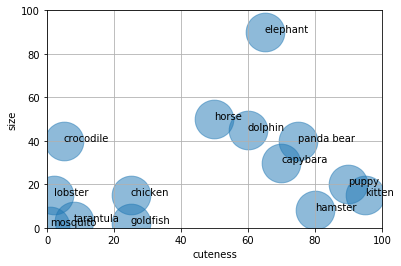

In [3]:
data.reset_index().plot(kind='scatter',x='cuteness',y='size',\
                       s=1500,alpha=0.5)
for index, row in data.iterrows():
    plt.text(row['cuteness'],row['size'],index)
plt.grid()
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

Using this plot, we can realize that the closest animal to the capybara is the panda bear. 

In this space, we can quantify how similar two animals are based on their euclidean distance in the space.

In [4]:
def get_animal_array_data( animal ):
    return np.array(data.loc[animal].tolist())

In [5]:
def distance2d( vec1, vec2 ):
    return np.sqrt( np.dot( vec1-vec2,\
                           vec1-vec2 ) )

In [6]:
def get_animal_distances( animal1, animal2 ):
    animal1 = get_animal_array_data(animal1)
    animal2 = get_animal_array_data(animal2)
    return distance2d(animal1, animal2)

In [7]:
print("Distance between a panda bear and capybara: {}".format(get_animal_distances('panda bear','capybara')))
print("Distance between a tarantula and elephant: {}".format(get_animal_distances('tarantula','elephant')))

Distance between a panda bear and capybara: 11.180339887498949
Distance between a tarantula and elephant: 104.0096149401583


We can also write a function to, given a point in animal space, determine the animal that is closest to that point.

In [8]:
def extrapolate_animal_from_point(cuteness, size):
    target_vec = np.array([cuteness,size])
    min_distance = np.inf
    min_distance_animal = ""
    for index, row in data.iterrows():
        distance = distance2d(target_vec, get_animal_array_data(index))
        if distance < min_distance:
            min_distance = distance
            min_distance_animal = index
    return min_distance_animal

The closest animal to size 25 and cuteness 30 should be chicken:

In [9]:
target_vec = [30,25]
minimal_dist_animal = extrapolate_animal_from_point(*target_vec)
print("Animal closest to point ({},{}): {}".format(*target_vec, minimal_dist_animal))

Animal closest to point (30,25): chicken


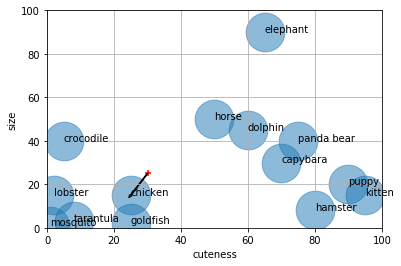

In [10]:
data.reset_index().plot(kind='scatter',x='cuteness',y='size',\
                       s=1500,alpha=0.5)
for index, row in data.iterrows():
    plt.text(row['cuteness'],row['size'],index)
plt.scatter(*target_vec,c='r',marker='+')
minimal_animal = get_animal_array_data(minimal_dist_animal)
vector_diff = (minimal_animal - np.array(target_vec)).tolist()
plt.arrow(*target_vec,*vector_diff,width=0.3 )
plt.grid()
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

Now let's talk about the vector space of colors. Colors are often represented in computers as vectors with three dimensions: red, green and blue. We'll be using the xkcd data file on colors from [here](https://github.com/dariusk/corpora/blob/master/data/colors/xkcd.json).

A color's RGB vector is converted into a hexadecimal number by converting each of the red, green and blue values into their hexadecimal counterparts and cocnatenating them. The resulting 6 digit number is the hexadecimal number.

In [11]:
import json

In [12]:
color_data = json.loads(open("data/xkcd_colors.json").read())

Colors are represented in hexadecimal format, so we need a function to convert hexadecimal into a tuple of integers:

In [13]:
def hex_to_int( s ):
    # each number is preceded by a pound
    s = s.lstrip("#")
    # int(string, base)
    return np.array([int(s[:2], 16), int(s[2:4], 16), int(s[4:6], 16)])

Now we can create a dictionary containing the mappings between the color names to their RGB vectors.

In [14]:
colors = {}
for color in color_data['colors']:
    colors[color['color']] = hex_to_int(color['hex'])

Now we can test it out:

In [15]:
colors['olive']

array([110, 117,  14])

In [16]:
np.array(list(colors['red']))

array([229,   0,   0])

In [17]:
def from_tuple_to_np_array( my_tuple ):
    return np.array(list(my_tuple))

def distance_between_colors( color1, color2 ):
    return np.linalg.norm(from_tuple_to_np_array(colors[color1])-\
                                from_tuple_to_np_array(colors[color2]))
def distance_between_coords( coord1, coord2 ):
    return np.linalg.norm(coord1-coord2)

In [18]:
print(distance_between_colors('red','green'))
print(distance_between_colors('red','pink'))

273.70787347096905
232.76812496559748


In order to find the closest colors to some point in RGB space, we can simply compute the distance between our point and every color in the space, then we sort this list. 

In [19]:
def closest( space, coord, n=10 ):
    closest = []
    for key in sorted(space.keys(), key=lambda x: \
        distance_between_coords(from_tuple_to_np_array(space[x]),\
                                from_tuple_to_np_array(coord)))[:n]:
        closest.append(key)
    return closest

In [20]:
closest(colors, colors['red'])

['red',
 'fire engine red',
 'bright red',
 'tomato red',
 'cherry red',
 'scarlet',
 'vermillion',
 'orangish red',
 'cherry',
 'lipstick red']

In [21]:
closest(colors, [150,60,150])

['warm purple',
 'medium purple',
 'ugly purple',
 'light eggplant',
 'purpleish',
 'purplish',
 'purply',
 'light plum',
 'purple',
 'muted purple']

By representing words as vectors in this vector space, we can use the vector operations to operate on those vectors in intuitive ways. For example, purple minus red yields blue:

In [22]:
closest(colors, colors['purple']-colors['red'])

['cobalt blue',
 'royal blue',
 'darkish blue',
 'true blue',
 'royal',
 'prussian blue',
 'dark royal blue',
 'deep blue',
 'marine blue',
 'deep sea blue']

Similarly, we can look at what green plus blue would look like:

In [23]:
closest(colors, colors['blue'] + colors['green'])

['bright turquoise',
 'bright light blue',
 'bright aqua',
 'cyan',
 'neon blue',
 'aqua blue',
 'bright cyan',
 'bright sky blue',
 'aqua',
 'bright teal']

And finally, what happens if we take the average of black and white? (gray)

In [24]:
def meanv( list_of_vecs ):
    mean = np.zeros(shape=list_of_vecs[0].shape)
    for vector in list_of_vecs:
        mean += vector
    return mean / len(list_of_vecs)

In [25]:
closest(colors, meanv([colors['black'],colors['white']]))

['medium grey',
 'purple grey',
 'steel grey',
 'battleship grey',
 'grey purple',
 'purplish grey',
 'greyish purple',
 'steel',
 'warm grey',
 'green grey']

Now, as an academic example, we can compute the average color of the text version of Dracula:

In [26]:
import spacy
nlp = spacy.load("en")

In [27]:
text = nlp( open("data/dracula.txt").read() )

In [28]:
drac_colors = [colors[word.lower_] for word in text if word.lower_ in colors]

In [29]:
print(drac_colors[:10])

[array([229,   0,   0]), array([244, 208,  84]), array([255, 255, 255]), array([255, 255, 255]), array([255, 255, 255]), array([172, 116,  52]), array([0, 0, 0]), array([0, 0, 0]), array([27, 36, 49]), array([ 78,  81, 139])]


In [30]:
def mean_of_vectors( list_of_colors ):
    summy = np.zeros(shape=list_of_colors[0].shape)
    for tuplee in list_of_colors:
        summy += from_tuple_to_np_array(tuplee)
    return summy / len(list_of_colors)

In [31]:
avg_color = mean_of_vectors(drac_colors)
print(avg_color)

[126.33898305 120.33898305 108.49152542]


Now we can figure out what color corresponds most closely to this location in our vector space

In [32]:
closest(colors, avg_color)

['brownish grey',
 'medium grey',
 'brown grey',
 'purplish grey',
 'green grey',
 'grey brown',
 'reddish grey',
 'purple grey',
 'battleship grey',
 'slate green']

**Distributional Semantics**

For colors, the example is interesting because we think of colors that are close in RGB space as being close together. 

In our color vector space, vectors that are closer together are more likely to be synonyms, or words that sort of mean the same thing.  For many purposes, the words that are close in our semantic space are also more likely to be functionally identical. 

For example, if someone searches on google for "mauve trousers", it is probably also reasonable to show them results for:

In [33]:
for color_name in closest(colors, colors['mauve']):
    print("{} trousers".format(color_name))

mauve trousers
dusty rose trousers
dusky rose trousers
brownish pink trousers
old pink trousers
reddish grey trousers
dirty pink trousers
old rose trousers
light plum trousers
ugly pink trousers


This works well for color words, which intuitively seem to exist in a multidimensional continuum of perception, and for the animal space, where we've written the vectors out ahead of time. 

But what about arbitrary words? Can we create a vector space for all English words that has this same "closer" in space means closer in meaning property?

In order to get an answer to that question, we need to ask what we mean when we talk about the _meaning_ of a word. 

One popular theory is to use the **Distributional Hypothesis**, which states that **Linguistic items with similar distributions have similar meanings**.

By **similar distributions**, we mean **similar contexts**. 

For example, consider the following sentences:
```text
It was really cold yesterday.
It will be really warm today, though.
It'll be really hot tomorrow!
Will it be really cool Tuesday?
```

According to the Distributional Hypothesis, the words, cold, warm, hot and cool must be related in some way (perhaps close in meaning) because they occur in a similar context - they all appear between the word "really" and a word referring to a particular day. In the same way, words like yesterday, today, tomorrow and Tuesday must all be related in a temporal way. 

So, according to the Distributional Hypothesis, **a word's meaning is a big list of all of the contexts it occurs in**. **Two words are closer in meaning if they share contexts**.

**Word Vectors by Counting Contexts**

So how do we use the Distributional Hypothesis to generate general-purpose vectors that capture the meaning of words? As a naive example, we could create a table in which each column refers to a single context you could find a word in, and each row is for the word in question. So for example, the column names would be ("START [word] was","it [word] the", "was [word] best", etc.)

Then, the entries of this table are the counts of that row's word in the given column's context.

Consider the sentence:
```text
It was the best of times, it was the worst of times.
```

We tokenize the sentence, and add a START character as well as an END character to pad the contexts:
```python
tokens = ["START","It","was","the","best","of","times",",","it","was","the","worst","of","times","END"]
```
We create a sliding window of 3 elements at a time to produce our 12 contexts:

Then we see that there are 12+2=14 words, and this yields 12 contexts: ("START [word] was",...,"of [word] END")

We understand this as a 12 dimensional vector space. The vector for the word "of" is:
```python
of_contexts = [0,0,0,0,1,0,0,0,0,0,1,0]
```

This vector can be interpreted by noting the presence of 1's in the 5th and 11th positions. This means that the word "of" appears as the middle word in the 5th triplet, and the 11th triplet. Upon looking at the windows, we see that those windows are, respectively: 
```python
["best","of","times"]
["worst","of","times"]
```
We can see some close similarities between these two contexts. The first element contains words that are opposite adjectives, and the last word is literally the same.

We can see the power of the distributional model through this simple example.

**Contexts and dimensionality**

Because of the way in which we generate contexts, we see the dimensionality of the semantic space can quickly blow out of proportion. As a result, generally dimensionality reduction techniques are used to reduce the size of the vector space. Usually the size is reduced to some reasonable number of dimensions, such as 100-300, depending on the corpus and the application.

However, there is also the question of how to define context. In th toy example we used, we simply defined it as a pair of surrounding words. However, depending on your application, you might want to use a context with a bigger window (perhaps two words before and after your target word). Or use a non-contiguous window (skip a word before and after the given word). You could also remove stop words in your tokens, or lemmatize your words before you begin your analysis, so that two occurrences of words with different forms will count as the same context.

**GloVe Vectors**

You don't always have to create your own word vectors from scratch! Many researchers have created downloadable databases of pre-trained word vectors. One such project is Stanfords Global Vectors for Word Representations (GloVe). These 300-dimensional vectors are what's used with the spaCy package in python. We will practice using these word vectors in this tutorial.


In [34]:
import spacy
nlp = spacy.load("en_core_web_lg")

Let's grab the words from dracula and create a unique list of words in the text:

In [35]:
tokens = list(set([w.text for w in text if w.is_alpha]))

To make them compact and fast, spaCy’s small models (all packages that end in sm) don’t ship with word vectors, and only include context-sensitive tensors. This means you can still use the similarity() methods to compare documents, spans and tokens – but the result won’t be as good, and individual tokens won’t have any vectors assigned. So in order to use real word vectors, you need to download a larger model:
```git
+ python -m spacy download en_core_web_lg
```


You can access the word vector of any word in spaCy's vocabulary using the `vocab` attribute:

In [36]:
print(nlp.vocab['cheese'].vector)

[-5.5252e-01  1.8894e-01  6.8737e-01 -1.9789e-01  7.0575e-02  1.0075e+00
  5.1789e-02 -1.5603e-01  3.1941e-01  1.1702e+00 -4.7248e-01  4.2867e-01
 -4.2025e-01  2.4803e-01  6.8194e-01 -6.7488e-01  9.2401e-02  1.3089e+00
 -3.6278e-02  2.0098e-01  7.6005e-01 -6.6718e-02 -7.7794e-02  2.3844e-01
 -2.4351e-01 -5.4164e-01 -3.3540e-01  2.9805e-01  3.5269e-01 -8.0594e-01
 -4.3611e-01  6.1535e-01  3.4212e-01 -3.3603e-01  3.3282e-01  3.8065e-01
  5.7427e-02  9.9918e-02  1.2525e-01  1.1039e+00  3.6678e-02  3.0490e-01
 -1.4942e-01  3.2912e-01  2.3300e-01  4.3395e-01  1.5666e-01  2.2778e-01
 -2.5830e-02  2.4334e-01 -5.8136e-02 -1.3486e-01  2.4521e-01 -3.3459e-01
  4.2839e-01 -4.8181e-01  1.3403e-01  2.6049e-01  8.9933e-02 -9.3770e-02
  3.7672e-01 -2.9558e-02  4.3841e-01  6.1212e-01 -2.5720e-01 -7.8506e-01
  2.3880e-01  1.3399e-01 -7.9315e-02  7.0582e-01  3.9968e-01  6.7779e-01
 -2.0474e-03  1.9785e-02 -4.2059e-01 -5.3858e-01 -5.2155e-02  1.7252e-01
  2.7547e-01 -4.4482e-01  2.3595e-01 -2.3445e-01  3

We create a helper function that returns the word vector from spaCy's vocabulary, given a string

In [37]:
def vec(s):
    return nlp.vocab[s].vector

**Cosine Similarity**

The cosine similarity is a metric used for determining how similar two vectors are, and is well-suited for high-dimensional spaces. 

In [38]:
def cosine(vec1, vec2):
    if np.linalg.norm(vec1)>0 and np.linalg.norm(vec2)>0:
        return np.dot(vec1,vec2) / (np.linalg.norm(vec1)*np.linalg.norm(vec2))
    else:
        return 0.0

As a sanity check, the word "dog" should be more similar to "puppy" than "dog" is to "octopus":

In [39]:
cosine(vec("dog"), vec("puppy")) > cosine(vec("dog"),vec("octopus"))

True

Now, we create a function that iterates through a list of tokens, and returns the token whose vector is most similar to a given vector:

In [40]:
def spacy_closest( token_list, vec_to_check, n=10 ):
    return sorted(token_list, key=lambda x: cosine(vec_to_check,vec(x)),reverse=True)[:n]

We can use this function to get a list of synonyms, or the n closest words in meaning to our target word:

In [41]:
spacy_closest(tokens, vec("basketball"))

['coach',
 'guard',
 'Court',
 'streak',
 'bench',
 'beat',
 'history',
 'men',
 'jump',
 'national']

Now we can have some fun with word vectors. What is the word that is closest to the halfway point between day and night (which is found in dracula)?

In [42]:
spacy_closest(tokens, meanv([vec("day"),vec("night")]))

['night',
 'day',
 'Day',
 'evening',
 'morning',
 'afternoon',
 'last',
 'days',
 'hour',
 'time']

Here are the closest words in Dracula to the word wine:

In [43]:
spacy_closest(tokens, vec("wine"))

['wine',
 'bottle',
 'drink',
 'fruit',
 'brandy',
 'coffee',
 'cheese',
 'dinner',
 'sparkling',
 'glass']

What would happen if we subtract alcohol from wine and find those closest words?

In [44]:
spacy_closest(tokens, vec("wine")-vec("alcohol"))

['wine',
 'fabulous',
 'splendid',
 'magnificent',
 'dinner',
 'sparkling',
 'dining',
 'charming',
 'salad',
 'farmhouse']

What about the words closest to water?

In [45]:
spacy_closest(tokens, vec("Water"))

['water',
 'waters',
 'pond',
 'sea',
 'lake',
 'cold',
 'river',
 'air',
 'rivers',
 'clean']

If you add frozen to water, you should get ice:

In [46]:
spacy_closest(tokens, vec("water")+vec("frozen"))

['water',
 'cold',
 'ice',
 'fresh',
 'dried',
 'waters',
 'pond',
 'sea',
 'ground',
 'lake']

We can do analogies by finding the words closest to the difference vector between two concepts:

sky is to blue and grass is to __

In [47]:
blue_to_sky = vec("blue") - vec("sky")
spacy_closest(tokens, blue_to_sky + vec("grass"))

['grass',
 'green',
 'red',
 'Red',
 'purple',
 'pink',
 'Blue',
 'blue',
 'orange',
 'brown']

**Sentence Similarity**

Now we can get the vector for a sentence by performing some component-wise aggregation over the word vectors for the words in the sentence:

In [48]:
def sentvec( sentence ):
    sentence = nlp(sentence)
    return np.mean([word.vector for word in sentence],axis=0)

Use spaCy to get a list of sentences:

In [49]:
sentences = list(text.sents)

In [50]:
first_sentence = sentences[0]
print(np.mean([word.vector for word in first_sentence],axis=0).shape)

(384,)


Use spaCy to find closest sentence:

In [51]:
def spacy_closest_sent( sentences, target_sentence, n=10 ):
    input_vec = sentvec(target_sentence)
    print(len(input_vec))
    return sorted(sentences, key=lambda sentence:cosine(np.mean([word.vector for word in sentence],axis=0), \
                        target_sentence), reverse=True)[:n]

In [52]:
for sent in spacy_closest_sent(sentences,"My favorite food is strawberry ice cream."):
    print(sent.text)
    print("---")

300


ValueError: could not convert string to float: 'My favorite food is strawberry ice cream.'

**Further Resources**

**Word2Vec** is another procedure for producing word vectors, which uses a predictive approach rather than a context-counting approach. 

If you want to train your own word vectors on a particular corpus, the python library **gensim** is a popular one that has an implementation of **Word2Vec**.

When you're working with high dimensional vector spaces, iterating through the entire space can cause too many cosine similarities to be calculated, so use the **Annoy** package to make those calculations faster